In [1]:
library(muhaz)
library(tidyverse)
library(lubridate)
library(knitr)
library(survival)
library(dplyr)
library(ggplot2)
library(purrr)
library(viridis)

Warning message:
"package 'muhaz' was built under R version 4.4.3"
Warning message:
"package 'tidyverse' was built under R version 4.4.3"
Warning message:
"package 'ggplot2' was built under R version 4.4.3"
Warning message:
"package 'readr' was built under R version 4.4.3"
Warning message:
"package 'forcats' was built under R version 4.4.3"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   4.0.0     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"package 'viridis' was built under R version 4.4.3"
Loading required package: viridisLite



---
# Data Cleaning

In [2]:
# https://data.sciencespo.fr/dataset.xhtml?persistentId=doi:10.21410/7E4/RDAG3O
bhht <- read.csv("../cross-verified-database.csv.gz")
# bhht <- read.csv("bhht_small.csv.gz")

bhht %>% colnames %>% sort

[1] "all_geography_groups"     "approx_birth"            
 [3] "approx_death"             "area1_of_rattachment"    
 [5] "area2_of_rattachment"     "bigperiod_birth"         
 [7] "bigperiod_birth_graph_b"  "bigperiod_death"         
 [9] "bigperiod_death_graph_b"  "birth"                   
[11] "birth_estimation"         "birth_max"               
[13] "birth_min"                "bpla1"                   
[15] "bplo1"                    "citizenship_1_b"         
[17] "citizenship_2_b"          "curid"                   
[19] "death"                    "death_estimation"        
[21] "death_max"                "death_min"               
[23] "dpla1"                    "dplo1"                   
[25] "freq_main_occ"            "freq_second_occ"         
[27] "gender"                   "group_wikipedia_editions"
[29] "level1_main_occ"          "level2_main_occ"         
[31] "level2_second_occ"        "level3_all_occ"          
[33] "level3_main_occ"          "list_areas_of_rattach"   
[35] "list_wikipedia_editions"  "name"                    
[37] "non_missing_score"        "number_wiki_editions"    
[39] "pantheon_1"               "ranking_visib_5criteria" 
[41] "string_citizenship_raw_d" "sum_visib_ln_5criteria"  
[43] "total_count_words_b"      "total_noccur_links_b"    
[45] "un_region"                "un_subregion"            
[47] "updated_death_date"       "wiki_readers_2015_2018"  
[49] "wikidata_code"

## Filter to past 100 years

In [3]:
current_year <- 2025
cutoff_year  <- 1925

bhht_clean <- bhht %>%
mutate(
# Convert to integers
  birth = as.integer(birth),
  death = as.integer(death),
  death_min = as.integer(death_min),
  death_max = as.integer(death_max),
  updated_death_year = suppressWarnings(year(ymd(updated_death_date))),

  # Choose best death year
  death_best = coalesce(updated_death_year, death, death_min, death_max),

  # Impute censoring for plausible living people
  death_final = case_when(
    !is.na(death_best) ~ death_best,
    birth >= cutoff_year ~ current_year,
    TRUE ~ NA_integer_
  ),

  birth_decade = floor(birth / 10) * 10,
  death_decade = floor(death_final / 10) * 10,

  status = if_else(!is.na(death_best), 1L, 0L),

  survival_time_age = death_final - birth,
  survival_time_year = death_final - cutoff_year

) %>%
  filter(
  !is.na(death_final),
  !is.na(birth),
  survival_time_age > 0,
  survival_time_age <= 122,
  # number_wiki_editions > 1,  # reliable?
  death_final >= cutoff_year # alive in last 100 years
) %>%
filter(
    gender != "", gender != "Other",
    un_region != "", un_region != "Other",
    level1_main_occ != "", level1_main_occ != "Other", level1_main_occ != "Missing"
)



bhht_clean %>% dim

[1] 1676602      57

In [4]:
# America first baby
bhht_clean$un_region <- factor(bhht_clean$un_region)
bhht_clean$un_region <- relevel(bhht_clean$un_region, ref = "America")

In [5]:
total_records <- nrow(bhht)
subset_records <- nrow(bhht_clean)

cat("Total records:", total_records, "\n")
cat("Subset records after cleaning:", subset_records, "\n")
cat("Proportion retained:", round(subset_records / total_records, 4) * 100, "%\n")

Total records: 2291817 
Subset records after cleaning: 1676602 
Proportion retained: 73.16 %


---
# EDA

In [6]:
bhht_clean$survival_time_age %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00   48.00   66.00   63.56   79.00  122.00 

In [7]:
# Lifespan summaries
summary(bhht_clean$survival_time_age)
summary(bhht_clean$survival_time_year)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00   48.00   66.00   63.56   79.00  122.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   74.00  100.00   83.33  100.00  100.00 

In [8]:
table(bhht_clean$status)
# Proportion censored
prop.table(table(bhht_clean$status))


      0       1 
1041752  634850 


        0         1 
0.6213472 0.3786528 

In [9]:
bhht_clean %>%
    group_by(gender) %>%
    summarise(count = n()) %>%
    arrange(desc(count)) %>%
    kable(col.names = c("Gender", "Number of People"), caption = "Number of People per Gender")



Table: Number of People per Gender

|Gender | Number of People|
|:------|----------------:|
|Male   |          1367564|
|Female |           309038|

In [10]:
bhht_clean %>%
    group_by(un_region) %>%
    summarise(count = n()) %>%
    arrange(desc(count)) %>%
    kable(col.names = c("UN Region", "Number of People"), caption = "Number of People per UN Region")



Table: Number of People per UN Region

|UN Region | Number of People|
|:---------|----------------:|
|Europe    |           888639|
|America   |           500585|
|Asia      |           166420|
|Oceania   |            66598|
|Africa    |            54360|

In [11]:
bhht_clean$birth %>% summary

bhht_clean$death_final %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1810    1921    1951    1945    1974    2018 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1925    1999    2025    2008    2025    2025 

In [12]:
bhht_clean %>%
    group_by(un_subregion) %>%
    summarise(count = n()) %>%
    arrange(desc(count)) %>%
    kable(col.names = c("UN Subregion", "Number of People"), caption = "Number of People per UN Subregion")



Table: Number of People per UN Subregion

|UN Subregion                        | Number of People|
|:-----------------------------------|----------------:|
|Western Europe                      |           531719|
|Northern America                    |           371412|
|Southern Europe                     |           156176|
|Northern Europe                     |           109358|
|South America                       |            93303|
|Eastern Europe                      |            91386|
|Oceania Western World               |            65001|
|Eastern Asia                        |            59023|
|South Asia incl. Indian Peninsula   |            45090|
|Western Asia (Middle East Caucasus) |            38162|
|Central America                     |            23831|
|SouthEast Asia                      |            20423|
|West Africa                         |            15669|
|North Africa                        |            12152|
|Caribbean                           |      

## Distribution of Covariates

In [13]:
# Determine number of bins for histograms
num_bins <- bhht_clean$survival_time_age %>% unique() %>% length() / 4
num_bins <- ceiling(num_bins)
print(num_bins)

palette <- scale_fill_brewer(palette = "Set1")

[1] 31


### Distribution by Gender

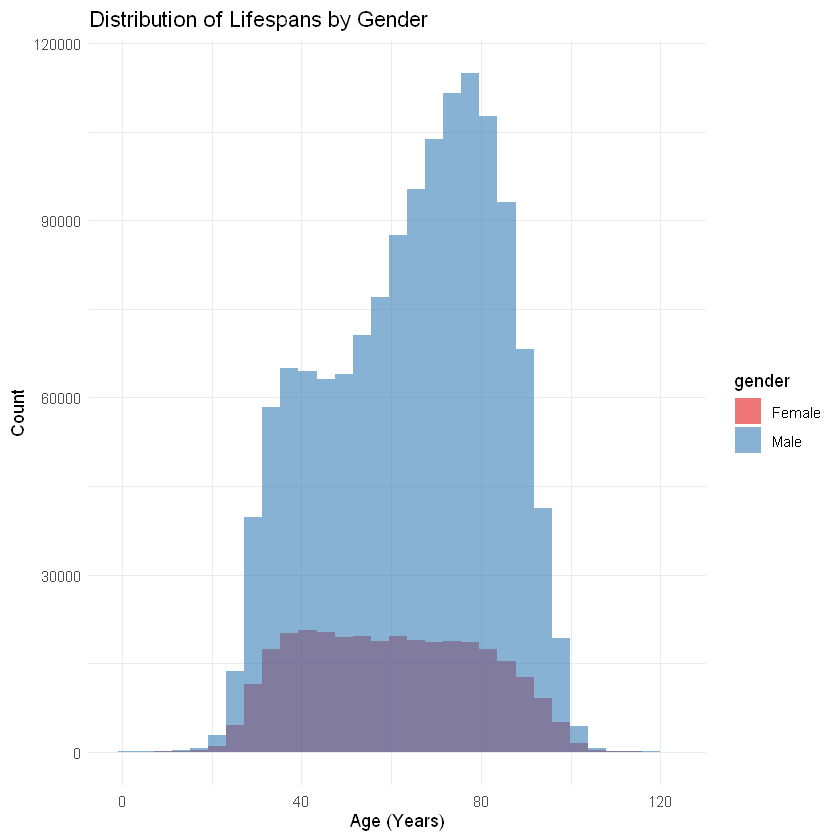

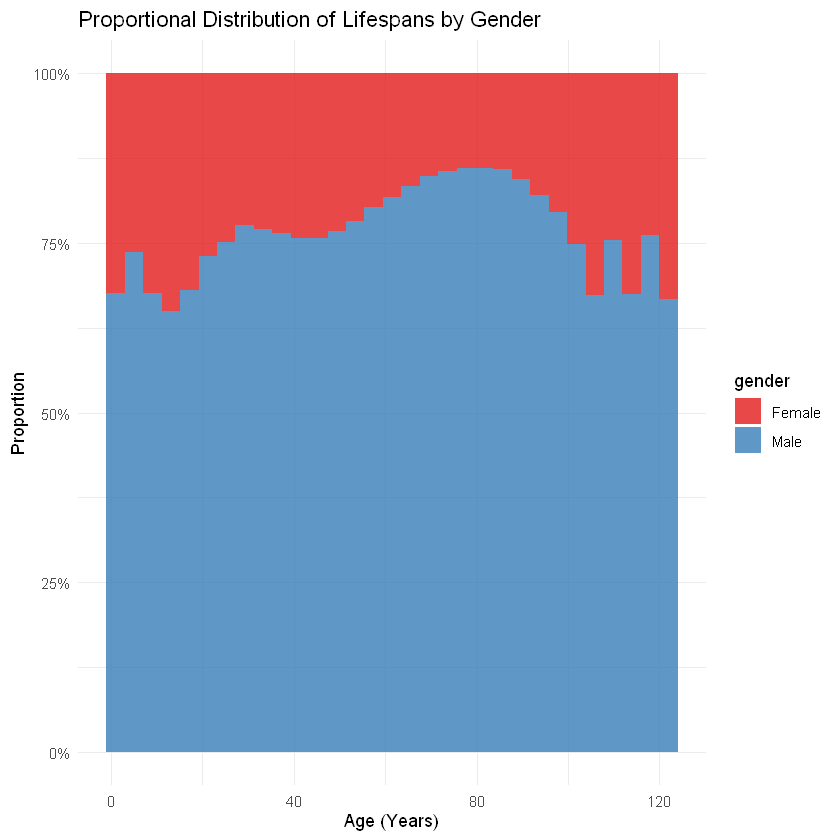

In [14]:
bhht_clean %>%
  filter(gender != "Missing", gender != "", !is.na(gender), gender != "Other") %>%
  ggplot(aes(x = survival_time_age, fill = gender)) +
  geom_histogram(bins = num_bins, position = "identity", alpha = 0.6) +
  palette +
  labs(title = "Distribution of Lifespans by Gender", x = "Age (Years)", y = "Count") +
  theme_minimal()

bhht_clean %>%
  filter(gender != "Missing", gender != "", !is.na(gender), gender != "Other") %>%
  ggplot(aes(x = survival_time_age, fill = gender)) +
  geom_histogram(bins = num_bins, position = "fill", alpha = 0.8) +
  palette +
  labs(
    title = "Proportional Distribution of Lifespans by Gender",
    x = "Age (Years)",
    y = "Proportion"
  ) +
  scale_y_continuous(labels = scales::percent_format()) +
  theme_minimal()

# bhht_clean %>%
#   ggplot(aes(x = survival_time_year, fill = gender)) +
#   geom_histogram(bins = num_bins, position = "identity", alpha = 0.6) +
#   labs(title = "Distribution of Lifespans by Gender", x = "Years Since 1925", y = "Count") +
#   theme_minimal()

### Distribution by UN Region

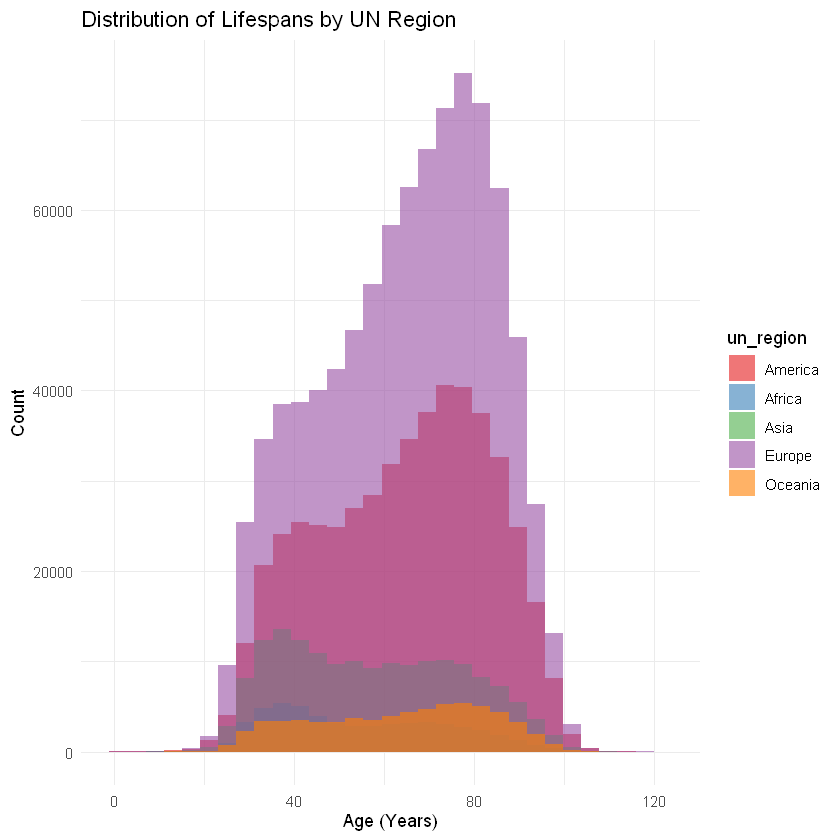

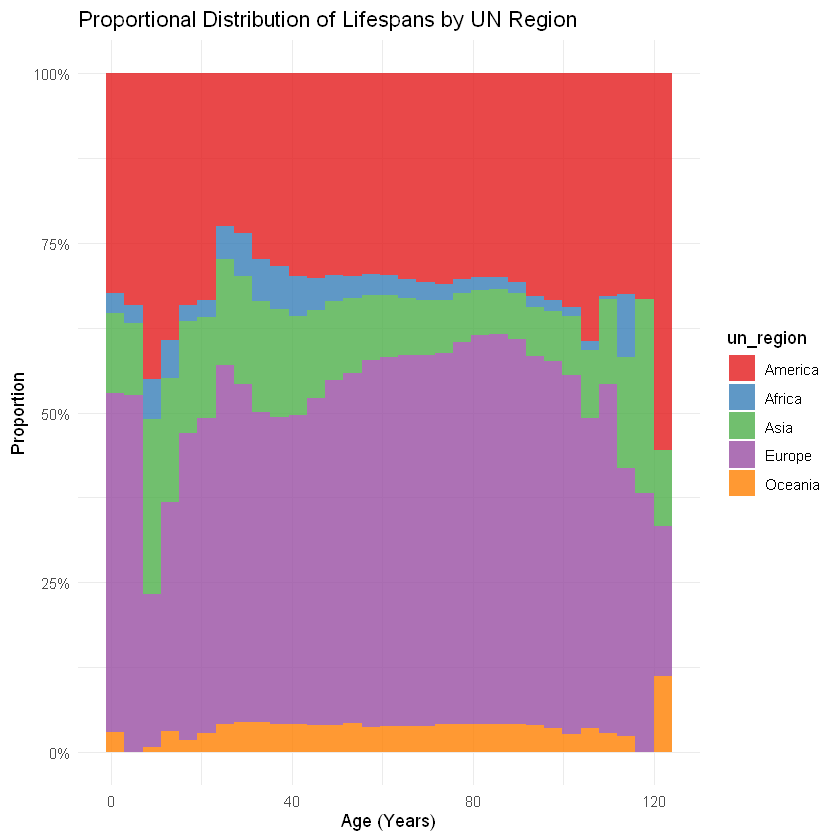

In [15]:
bhht_clean %>%
filter(un_region != "Missing") %>%
  ggplot(aes(x = survival_time_age, fill = un_region)) +
  geom_histogram(bins = num_bins, position = "identity", alpha = 0.6) +
  palette +
  labs(title = "Distribution of Lifespans by UN Region", x = "Age (Years)", y = "Count") +
  theme_minimal()

bhht_clean %>%
  filter(un_region != "Missing") %>%
  ggplot(aes(x = survival_time_age, fill = un_region)) +
  geom_histogram(bins = num_bins, position = "fill", alpha = 0.8) +
  palette +
  labs(
    title = "Proportional Distribution of Lifespans by UN Region",
    x = "Age (Years)",
    y = "Proportion"
  ) +
  scale_y_continuous(labels = scales::percent_format()) +
  theme_minimal()

# bhht_clean %>%
#   ggplot(aes(x = survival_time_year, fill = un_region)) +
#   geom_histogram(bins = num_bins, position = "identity", alpha = 0.6) +
#   labs(title = "Distribution of Lifespans by UN Region", x = "Years Since 1925", y = "Count") +
#   theme_minimal()

### By UN Subregion

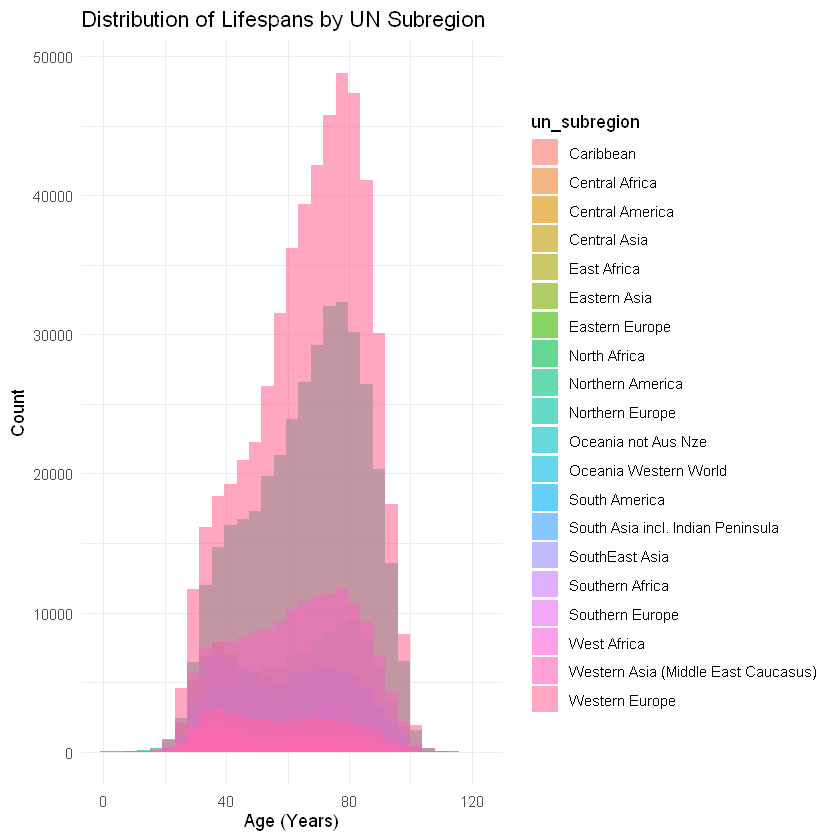

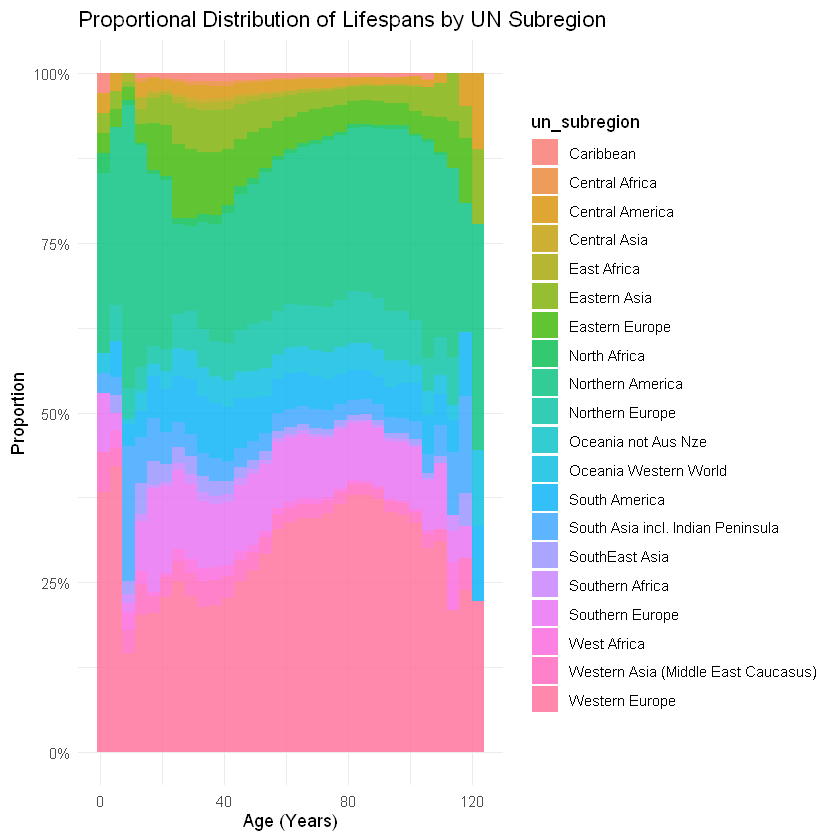

In [16]:
bhht_clean %>%
  filter(un_subregion != "Missing") %>%
  ggplot(aes(x = survival_time_age, fill = un_subregion)) +
  geom_histogram(bins = num_bins, position = "identity", alpha = 0.6) +
  # palette +
  labs(title = "Distribution of Lifespans by UN Subregion", x = "Age (Years)", y = "Count") +
  theme_minimal()

bhht_clean %>%
  filter(un_subregion != "Missing") %>%
  ggplot(aes(x = survival_time_age, fill = un_subregion)) +
  geom_histogram(bins = num_bins, position = "fill", alpha = 0.8) +
  # palette +
  labs(
    title = "Proportional Distribution of Lifespans by UN Subregion",
    x = "Age (Years)",
    y = "Proportion"
  ) +
  scale_y_continuous(labels = scales::percent_format()) +
  theme_minimal()

# bhht_clean %>%
#   ggplot(aes(x = survival_time_year, fill = un_subregion)) +
#   geom_histogram(bins = num_bins, position = "identity", alpha = 0.6) +
#   labs(title = "Distribution of Lifespans by UN Subregion", x = "Years Since 1925", y = "Count") +
#   theme_minimal()

### Distribution by L1 Occupation

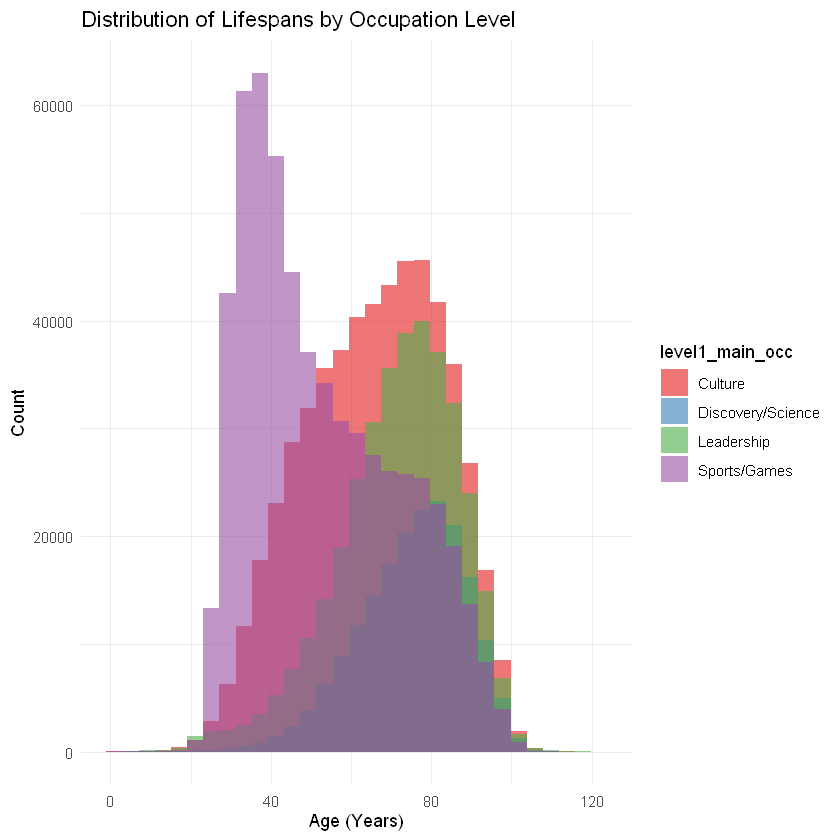

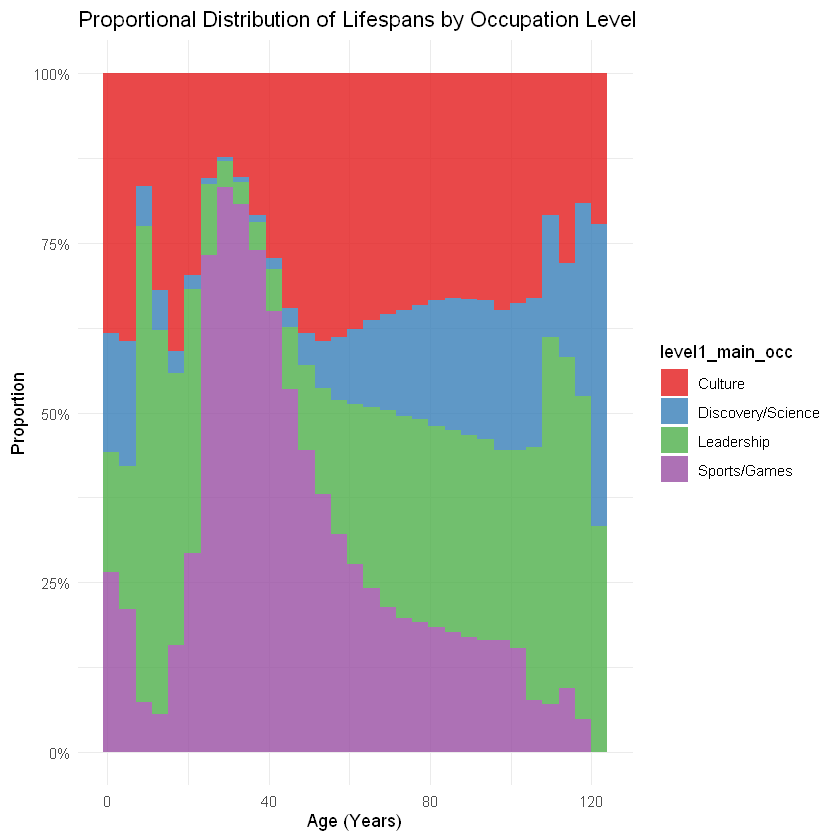

In [17]:
bhht_clean %>%
  filter(level1_main_occ != "Missing") %>%
  ggplot(aes(x = survival_time_age, fill = level1_main_occ)) +
  geom_histogram(bins = num_bins, position = "identity", alpha = 0.6) + 
  palette +
  labs(title = "Distribution of Lifespans by Occupation Level", x = "Age (Years)", y = "Count") +
  theme_minimal()

bhht_clean %>%
  filter(level1_main_occ != "Missing") %>%
  ggplot(aes(x = survival_time_age, fill = level1_main_occ)) +
  geom_histogram(bins = num_bins, position = "fill", alpha = 0.8) + 
  palette +
  labs(
    title = "Proportional Distribution of Lifespans by Occupation Level",
    x = "Age (Years)",
    y = "Proportion"
  ) +
  scale_y_continuous(labels = scales::percent_format()) +
  theme_minimal()


# bhht_clean %>%
#   ggplot(aes(x = survival_time_year, fill = level1_main_occ)) +
#   geom_histogram(bins = num_bins, position = "identity", alpha = 0.6) +
#   labs(title = "Distribution of Lifespans by Occupation Level", x = "Years Since 1925", y = "Count") +
#   theme_minimal()

---
# Age Based Survival Analysis

## Overall

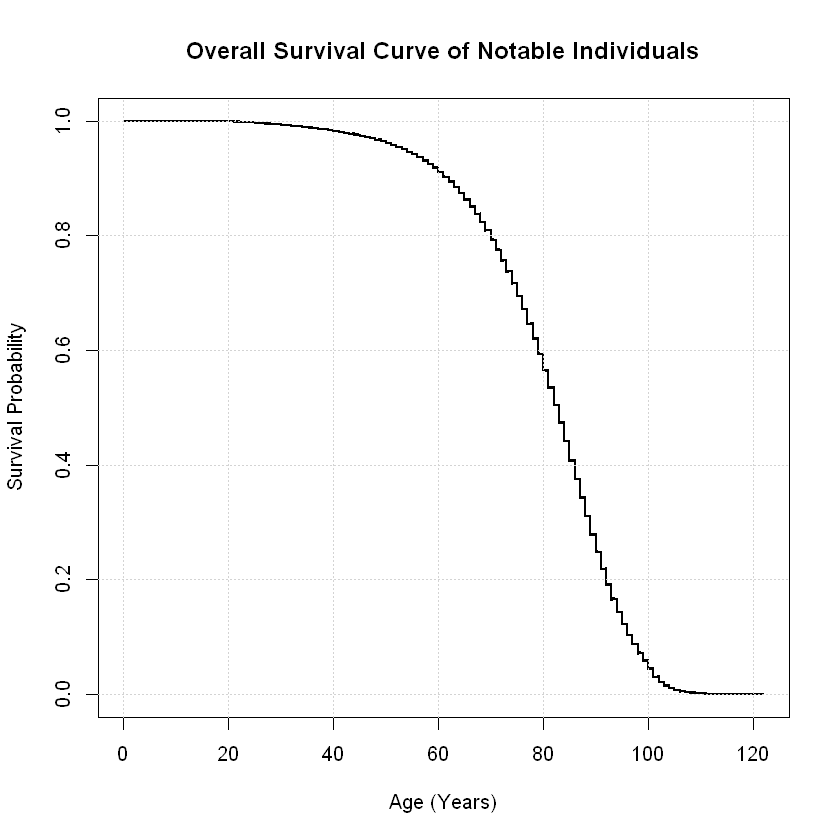

In [18]:
surv_obj <- Surv(time = bhht_clean$survival_time_age, event = bhht_clean$status)

km_fit <- survfit(surv_obj ~ 1, data = bhht_clean)

par(bg = 'white')
plot(km_fit,
     xlab = "Age (Years)",
     ylab = "Survival Probability",
     main = "Overall Survival Curve of Notable Individuals",
     col = "black",
     lwd = 2)
grid()

## By Gender

Call:
survdiff(formula = Surv(survival_time_age, status) ~ gender, 
    data = bhht_clean_gdr)

                    N Observed Expected (O-E)^2/E (O-E)^2/V
gender=Female  309038    74284   103928      8455     10686
gender=Male   1367564   560566   530922      1655     10686

 Chisq= 10686  on 1 degrees of freedom, p= <2e-16 

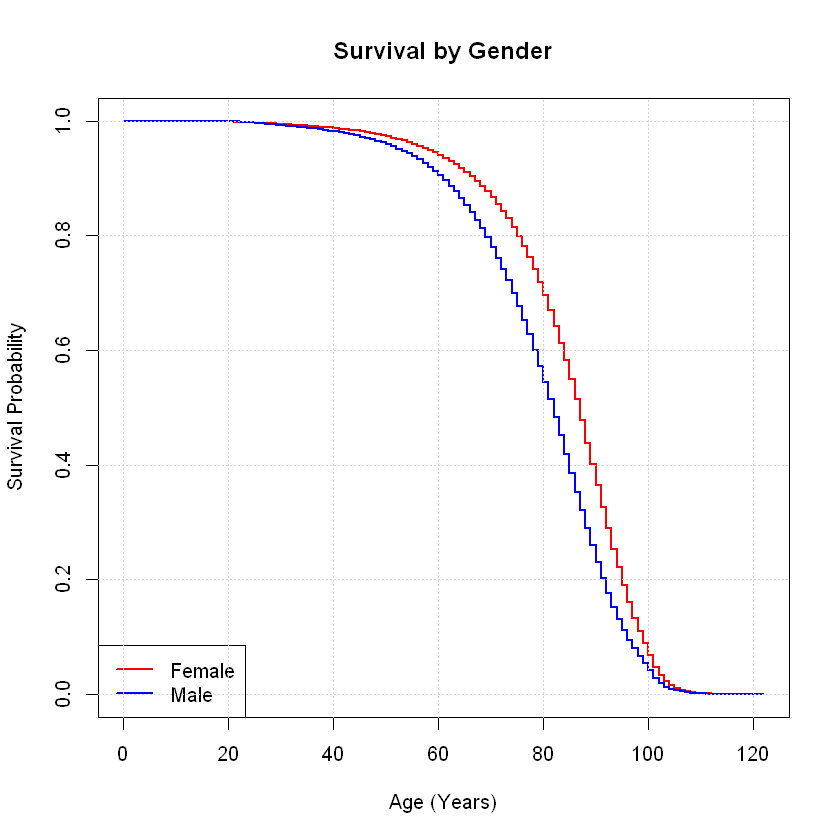

In [19]:
bhht_clean_gdr <- bhht_clean %>% filter(gender != "Other") %>% filter(!is.na(gender)) 
bhht_clean_gdr <- bhht_clean_gdr[!is.na(bhht_clean_gdr$gender) & 
                                 bhht_clean_gdr$gender != "Other" & 
                                 bhht_clean_gdr$gender != "", ]


surv_obj_age <- Surv(time = bhht_clean_gdr$survival_time_age, event = bhht_clean_gdr$status)
km_fit_gender <- survfit(surv_obj_age ~ gender, data = bhht_clean_gdr)

par(bg = 'white')
plot(km_fit_gender,
     xlab = "Age (Years)",
     ylab = "Survival Probability",
     main = "Survival by Gender",
     col = c("red", "blue"),
     lwd = 2)
legend("bottomleft", legend = levels(as.factor(bhht_clean_gdr$gender)),
       col = c("red", "blue"), lwd = 2)
grid()

# Log-rank test
survdiff(Surv(survival_time_age, status) ~ gender, data = bhht_clean_gdr)

Indicates that female individuals tend to live longer than their male counterparts among notable people in the past century.

## By UN Region

Call:
survdiff(formula = Surv(survival_time_age, status) ~ un_region, 
    data = bhht_clean_no_missing)

                       N Observed Expected (O-E)^2/E (O-E)^2/V
un_region=Africa   54360    10938    11956      86.7      92.2
un_region=America 500585   186815   198005     632.4     966.2
un_region=Asia    166420    39681    46916    1115.7    1265.8
un_region=Europe  888639   371553   353299     943.1    2234.5
un_region=Oceania  66598    25863    24674      57.3      62.5

 Chisq= 2979  on 4 degrees of freedom, p= <2e-16 

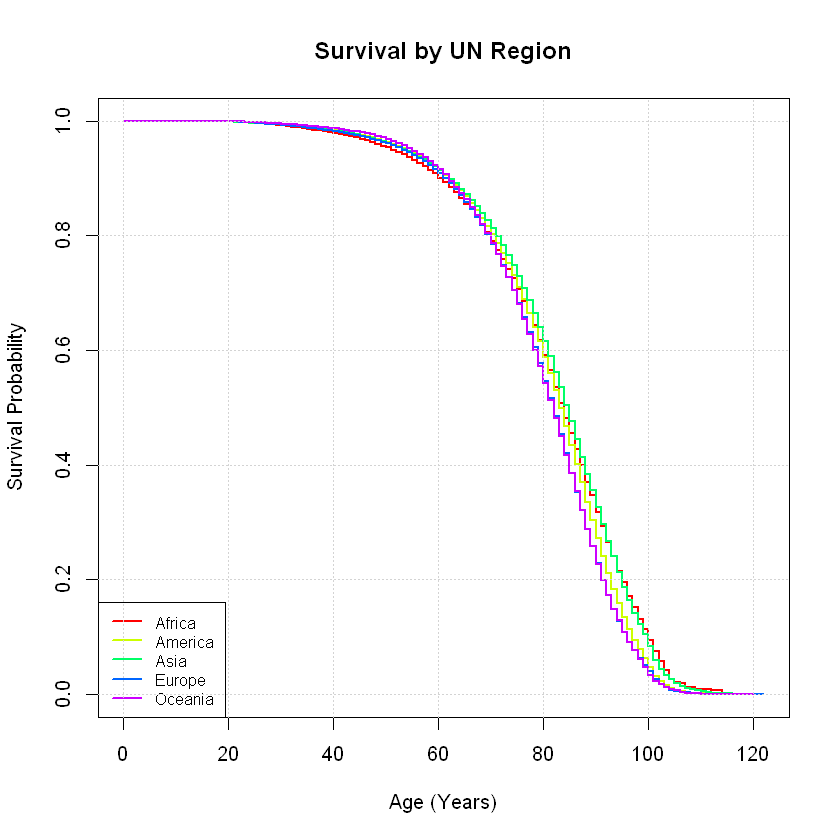

In [20]:
# Relabel missing regions
bhht_clean$un_region <- trimws(bhht_clean$un_region)
bhht_clean$un_region[bhht_clean$un_region %in% c("", " ", NA, "NA", "Missing", "Unknown", "None")] <- NA

bhht_clean_no_missing <- bhht_clean %>% filter( !is.na(un_region))

surv_obj_age <- Surv(time = bhht_clean_no_missing$survival_time_age, event = bhht_clean_no_missing$status)

km_fit_region <- survfit(surv_obj_age ~ un_region, data = bhht_clean_no_missing)

region_colors <- rainbow(length(unique(bhht_clean_no_missing$un_region)))
par(bg='white')
plot(km_fit_region,
     xlab = "Age (Years)",
     ylab = "Survival Probability",
     main = "Survival by UN Region",
     col = region_colors,
     lwd = 2)
legend("bottomleft", legend = levels(as.factor(bhht_clean_no_missing$un_region)),
       col = region_colors, lwd = 2, cex = 0.8)
grid()

# Log-rank test
survdiff(Surv(survival_time_age, status) ~ un_region, data = bhht_clean_no_missing)

## By UN Subregion

Call:
survdiff(formula = Surv(survival_time_age, status) ~ un_subregion, 
    data = bhht_clean_no_missing)

                                                      N Observed Expected
un_subregion=Caribbean                            12039     2987     3340
un_subregion=Central Africa                        4901      795      834
un_subregion=Central America                      23831     6320     7054
un_subregion=Central Asia                          3722      331      395
un_subregion=East Africa                          10290     1759     1988
un_subregion=Eastern Asia                         59023    11165    15350
un_subregion=Eastern Europe                       91386    29530    23876
un_subregion=North Africa                         12152     2699     3166
un_subregion=Northern America                    371412   149979   158696
un_subregion=Northern Europe                     109358    46775    45339
un_subregion=Oceania not Aus Nze                   1597      264      227
un_

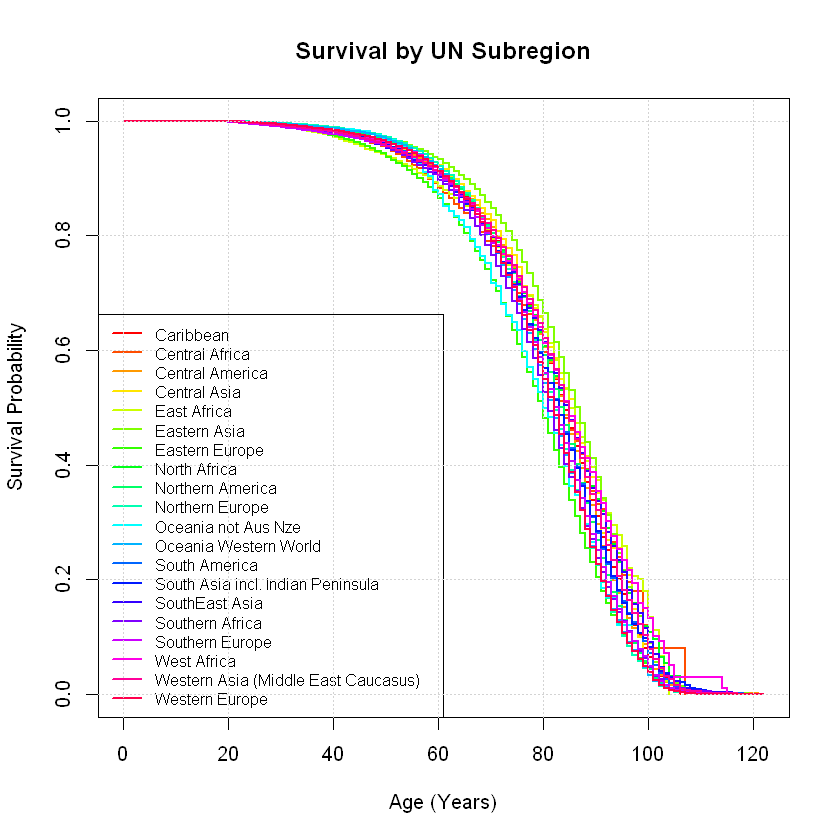

In [21]:
# Relabel missing regions
bhht_clean$un_subregion[bhht_clean$un_subregion == ""] <- "Missing"

bhht_clean_no_missing <- bhht_clean %>% filter(un_subregion != "Missing")

surv_obj_age <- Surv(time = bhht_clean_no_missing$survival_time_age, event = bhht_clean_no_missing$status)

km_fit_region <- survfit(surv_obj_age ~ un_subregion, data = bhht_clean_no_missing)

region_colors <- rainbow(length(unique(bhht_clean_no_missing$un_subregion)))
par(bg='white')
plot(km_fit_region,
     xlab = "Age (Years)",
     ylab = "Survival Probability",
     main = "Survival by UN Subregion",
     col = region_colors,
     lwd = 2)
legend("bottomleft", legend = levels(as.factor(bhht_clean_no_missing$un_subregion)),
       col = region_colors, lwd = 2, cex = 0.8)
grid()

# Log-rank test
survdiff(Surv(survival_time_age, status) ~ un_subregion, data = bhht_clean_no_missing)

## By L1 Occupation

Call:
survdiff(formula = Surv(survival_time_age, status) ~ level1_main_occ, 
    data = bhht_clean)

                                       N Observed Expected (O-E)^2/E (O-E)^2/V
level1_main_occ=Culture           545477   221713   215501       179       285
level1_main_occ=Discovery/Science 188611   103583   116059      1341      1736
level1_main_occ=Leadership        356019   197622   183523      1083      1604
level1_main_occ=Sports/Games      586495   111932   119768       513       666

 Chisq= 3280  on 3 degrees of freedom, p= <2e-16 

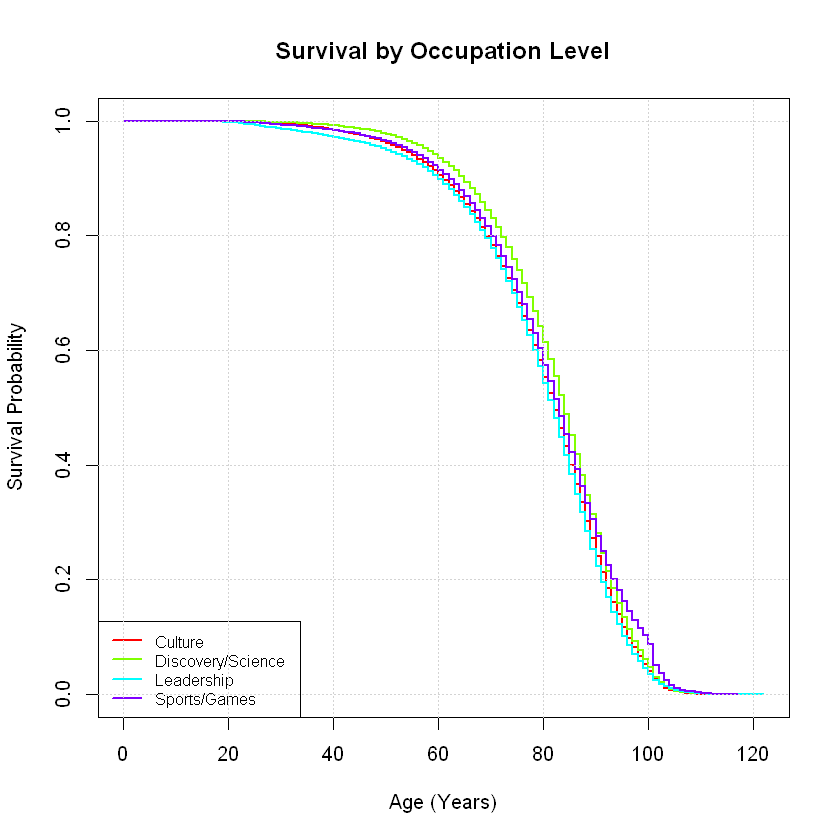

In [22]:
surv_obj_age <- Surv(time = bhht_clean$survival_time_age, event = bhht_clean$status)
km_fit_region <- survfit(surv_obj_age ~ level1_main_occ, data = bhht_clean)

region_colors <- rainbow(length(unique(bhht_clean$level1_main_occ)))

par(bg='white')
plot(km_fit_region,
     xlab = "Age (Years)",
     ylab = "Survival Probability",
     main = "Survival by Occupation Level",
     col = region_colors,
     lwd = 2)
legend("bottomleft", legend = levels(as.factor(bhht_clean$level1_main_occ)),
       col = region_colors, lwd = 2, cex = 0.8)
grid()

# Log-rank test
survdiff(Surv(survival_time_age, status) ~ level1_main_occ, data = bhht_clean)

## `survminer` curves 
- Just visualizes the same data in ggplot for the presentation
- Can tweak more if we want to use this

Warning message:
"package 'survminer' was built under R version 4.4.3"
Loading required package: ggpubr

Warning message:
"package 'ggpubr' was built under R version 4.4.3"

Attaching package: 'survminer'


The following object is masked from 'package:survival':

    myeloma


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
ℹ The deprecated feature was likely used in the ggpubr package.
  Please report the issue at <https://github.com/kassambara/ggpubr/issues>."


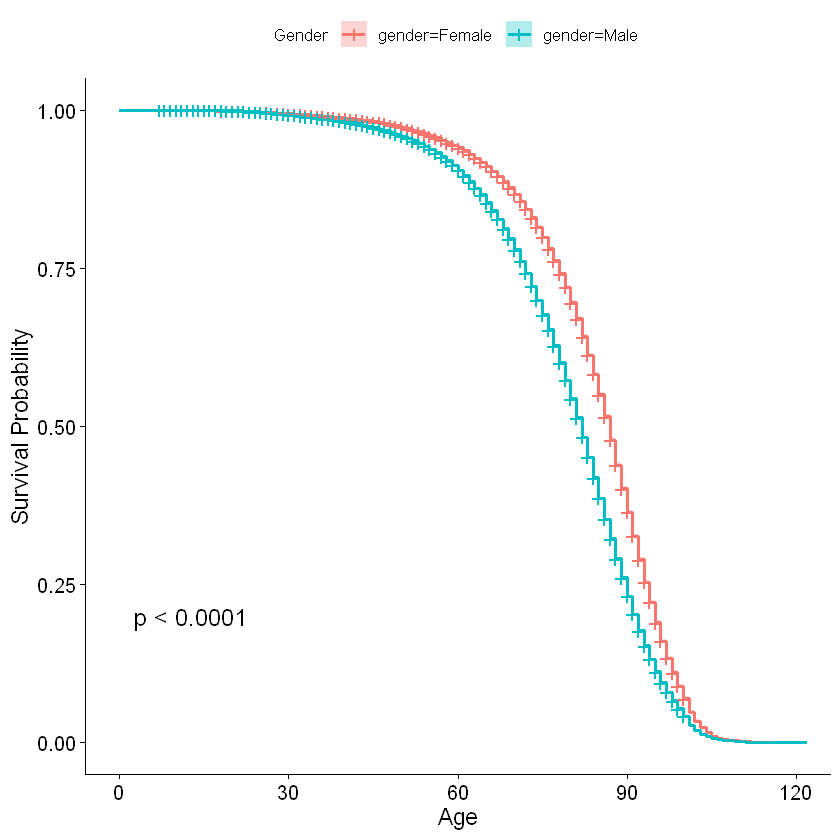

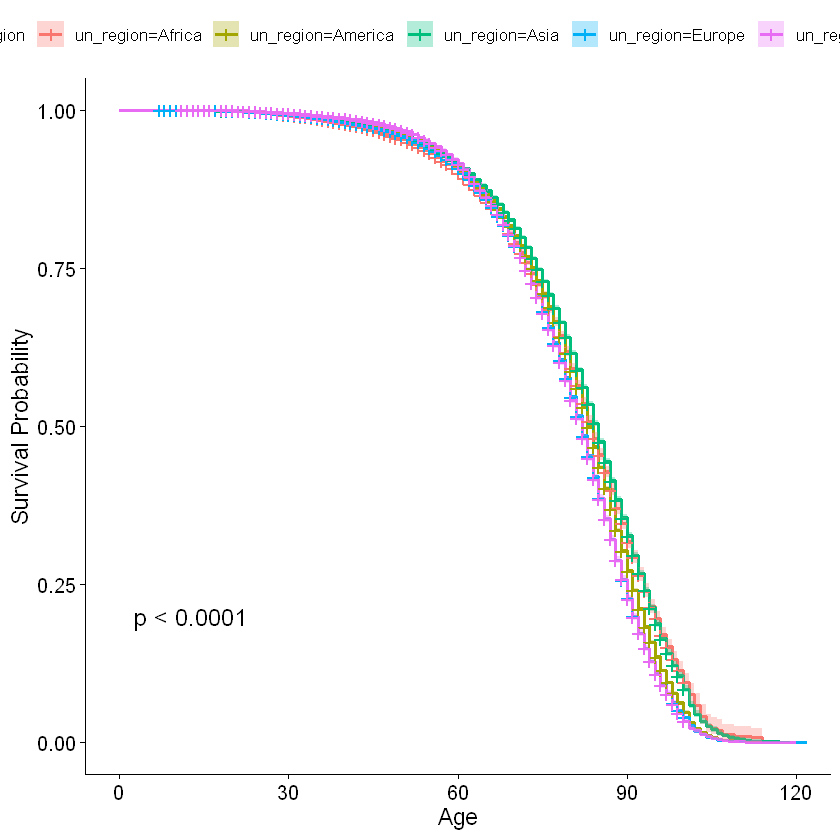

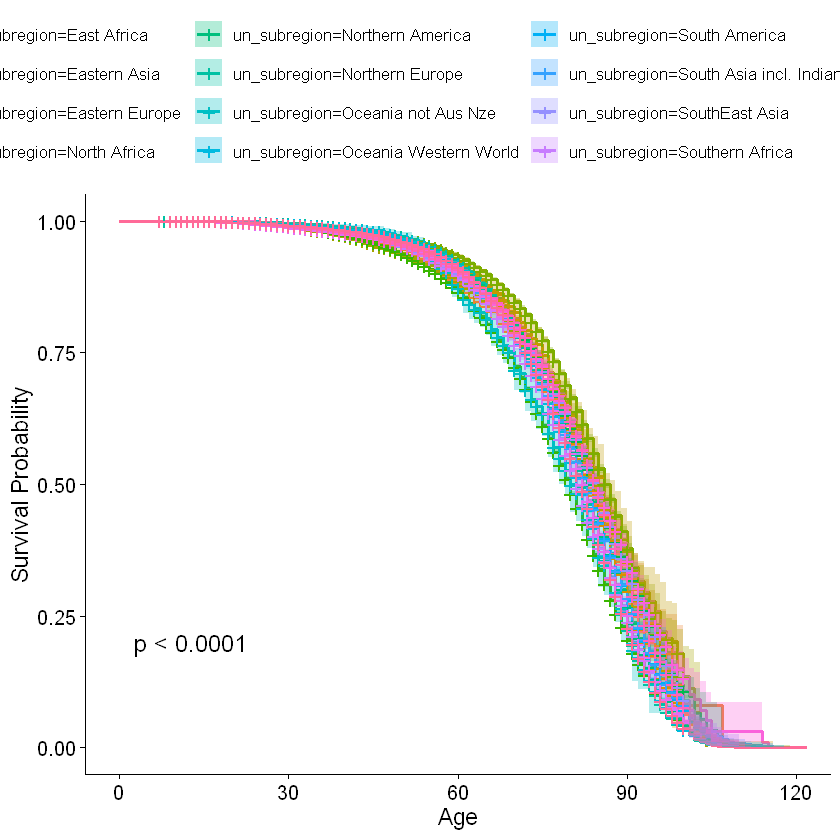

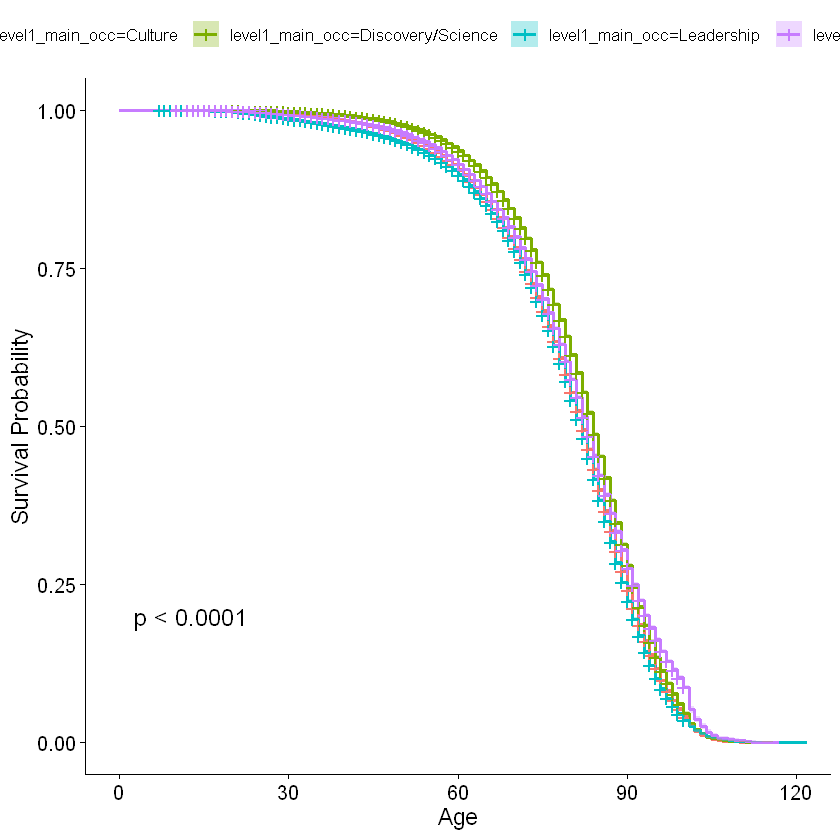

In [23]:
library(survival)
library(survminer)

# Compare survival curves across groups

km_gender <- survfit(Surv(survival_time_age, status) ~ gender, data = bhht_clean)
ggsurvplot(km_gender, conf.int = TRUE, pval = TRUE,
            legend.title = "Gender", xlab = "Age", ylab = "Survival Probability")

km_region <- survfit(Surv(survival_time_age, status) ~ un_region, data = bhht_clean)
ggsurvplot(km_region, conf.int = TRUE, pval = TRUE,
            legend.title = "Region", xlab = "Age", ylab = "Survival Probability")

km_subregion <- survfit(Surv(survival_time_age, status) ~ un_subregion, data = bhht_clean)
ggsurvplot(km_subregion, conf.int = TRUE, pval = TRUE,
            legend.title = "Subregion", xlab = "Age", ylab = "Survival Probability")

km_occupation <- survfit(Surv(survival_time_age, status) ~ level1_main_occ, data = bhht_clean)
ggsurvplot(km_occupation, conf.int = TRUE, pval = TRUE,
            legend.title = "Occupation", xlab = "Age", ylab = "Survival Probability")

---
## Cox Proportional Hazards Model

### Full Baseline Model

In [24]:
bhht_clean_filtered <- bhht_clean %>%
  mutate(
    gender = as.character(gender),
    un_region = as.character(un_region),
    level1_main_occ = as.character(level1_main_occ)
  ) %>%
  # Comment out filters if needed
  filter(
    !is.na(gender), gender != "Other", gender != "",
    !is.na(un_region), un_region != "Other", un_region != "Missing", un_region != "",
    !is.na(level1_main_occ), level1_main_occ != "Other", level1_main_occ != "Missing", level1_main_occ != ""
  ) %>%
  mutate(
    gender = factor(gender),
    un_region = factor(un_region),
    level1_main_occ = factor(level1_main_occ)
  ) %>%

  # Drop unused factor levels
  mutate(
    gender = droplevels(gender),
    un_region = droplevels(un_region),
    level1_main_occ = droplevels(level1_main_occ)
  )

bhht_clean_filtered$un_region <- relevel(bhht_clean_filtered$un_region, ref = "America")

levels(bhht_clean_filtered$gender)
levels(bhht_clean_filtered$un_region)
levels(bhht_clean_filtered$level1_main_occ)

[1] "Female" "Male"

[1] "America" "Africa"  "Asia"    "Europe"  "Oceania"

[1] "Culture"           "Discovery/Science" "Leadership"       
[4] "Sports/Games"

### Multivariate Cox Model

In [25]:
cox_age <- coxph(Surv(survival_time_age, status) ~ gender + un_region + level1_main_occ, data = bhht_clean_filtered)
summary(cox_age)

Call:
coxph(formula = Surv(survival_time_age, status) ~ gender + un_region + 
    level1_main_occ, data = bhht_clean_filtered)

  n= 1676602, number of events= 634850 

                                      coef exp(coef)  se(coef)       z Pr(>|z|)
genderMale                        0.422968  1.526485  0.003978 106.319  < 2e-16
un_regionAfrica                  -0.057090  0.944509  0.009856  -5.792 6.94e-09
un_regionAsia                    -0.138323  0.870817  0.005536 -24.986  < 2e-16
un_regionEurope                   0.107850  1.113880  0.002843  37.929  < 2e-16
un_regionOceania                  0.128557  1.137186  0.006687  19.224  < 2e-16
level1_main_occDiscovery/Science -0.198909  0.819625  0.003792 -52.455  < 2e-16
level1_main_occLeadership         0.001060  1.001061  0.003147   0.337    0.736
level1_main_occSports/Games      -0.170233  0.843469  0.003751 -45.385  < 2e-16
                                    
genderMale                       ***
un_regionAfrica                  ***


                chisq df      p
gender           1604  1 <2e-16
un_region         508  4 <2e-16
level1_main_occ  1441  3 <2e-16
GLOBAL           3515  8 <2e-16


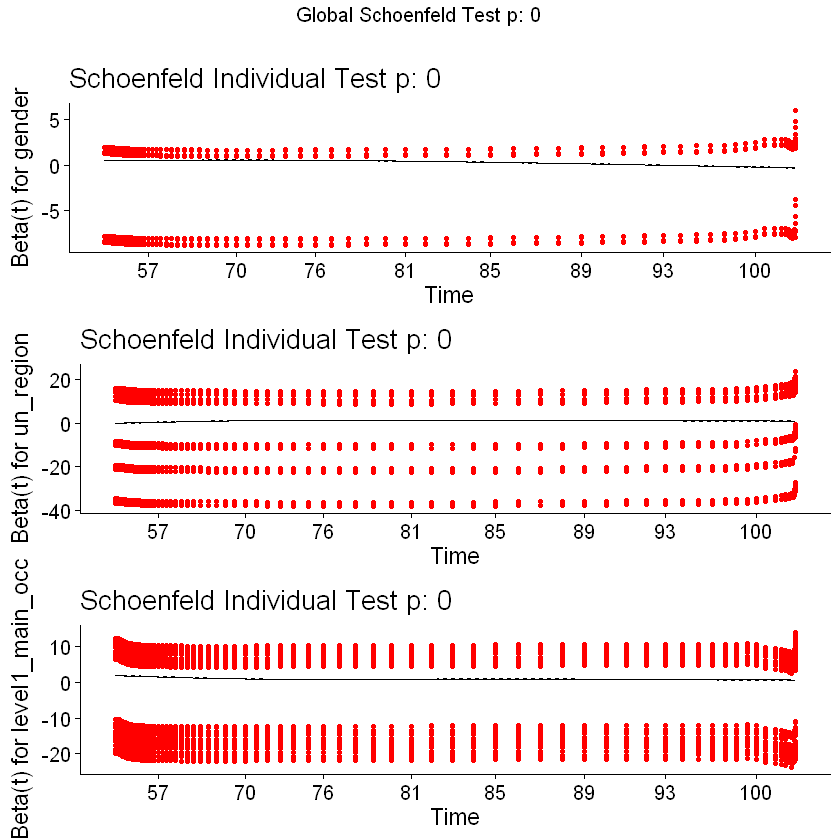

In [26]:
#### PH Diagnostics Check
ph_test <- cox.zph(cox_age)
print(ph_test)
ggcoxzph(ph_test)

In [27]:
### 1. Print the Cox model object type
print(class(cox_age))

### 2. How many coefficients are in the model?
cat("Number of coefficients in cox_age: ", length(coef(cox_age)), "\n")

### 3. Run PH test again (ensure correct model)
ph_age <- cox.zph(cox_age)

### 4. Print the PH test table (names and stats)
cat("\n--- PH test table ---\n")
print(ph_age)

### 5. List residual matrix dimensions and time vector length
cat("\n--- Residual matrix dimensions ---\n")
print(dim(ph_age$x))

cat("\nTime vector length: ", length(ph_age$time), "\n")

### 6. Check the structure of the PH object
cat("\n--- Structure of ph_age object ---\n")
str(ph_age)

### 7. Show the names of components inside ph_age
cat("\n--- Names inside ph_age ---\n")
print(names(ph_age))

### 8. Show the first few row names of ph_age$table
cat("\n--- Row names of PH test table ---\n")
print(row.names(ph_age$table))


[1] "coxph"
Number of coefficients in cox_age:  8 

--- PH test table ---
                chisq df      p
gender           1604  1 <2e-16
un_region         508  4 <2e-16
level1_main_occ  1441  3 <2e-16
GLOBAL           3515  8 <2e-16

--- Residual matrix dimensions ---
NULL

Time vector length:  634850 

--- Structure of ph_age object ---
List of 7
 $ table    : num [1:4, 1:3] 1604 508 1441 3515 1 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:4] "gender" "un_region" "level1_main_occ" "GLOBAL"
  .. ..$ : chr [1:3] "chisq" "df" "p"
 $ x        : num [1:634850] 0 0 0 0 0 0 0 0 0 0 ...
 $ time     : num [1:634850] 1 1 1 1 1 1 1 1 1 1 ...
 $ y        : num [1:634850, 1:3] 1.96 1.37 -8.4 -7.84 1.95 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:634850] "1" "1" "1" "1" ...
  .. ..$ : chr [1:3] "gender" "un_region" "level1_main_occ"
 $ var      : num [1:3, 1:3] 9.7893 0.0795 3.3894 0.0795 190.0242 ...
 $ transform: chr "km"
 $ call     : language cox.zph(fit = cox_age)
 

- All 3 plots have clear curvature and p-values of near 0. The global test having this means the proportional hazards assumption is violated.
- The effect of gender, region, and occupation on mortality risk DO change with age.
- I think we can simply state this, and don't need to rework this to hold anything constant or stratify on covariates.
    - Okay wait adding birth_decade stabilizes this

### Multivariate Cox Model (Cohort Control)

In [28]:
cox_model <- coxph(Surv(survival_time_age, status) ~ gender + un_region + level1_main_occ + birth_decade,
                   data = bhht_clean_filtered)

summary(cox_model)

# Exponentiate for interpretability
exp(cbind(HR = coef(cox_model), confint(cox_model)))

Call:
coxph(formula = Surv(survival_time_age, status) ~ gender + un_region + 
    level1_main_occ + birth_decade, data = bhht_clean_filtered)

  n= 1676602, number of events= 634850 

                                       coef  exp(coef)   se(coef)        z
genderMale                        0.3564205  1.4282080  0.0039999   89.107
un_regionAfrica                   0.1436028  1.1544255  0.0098709   14.548
un_regionAsia                     0.0027401  1.0027439  0.0055553    0.493
un_regionEurope                   0.0398316  1.0406355  0.0028543   13.955
un_regionOceania                  0.0275852  1.0279692  0.0066980    4.118
level1_main_occDiscovery/Science -0.2497554  0.7789913  0.0037967  -65.783
level1_main_occLeadership        -0.1121544  0.8939063  0.0031750  -35.325
level1_main_occSports/Games      -0.0295310  0.9709008  0.0037868   -7.798
birth_decade                     -0.0153840  0.9847338  0.0000421 -365.422
                                 Pr(>|z|)    
genderMale          

,HR,2.5 %,97.5 %
genderMale,1.4282080,1.4170551,1.4394488
un_regionAfrica,1.1544255,1.1323059,1.1769771
un_regionAsia,1.0027439,0.9918850,1.0137217
un_regionEurope,1.0406355,1.0348300,1.0464735
un_regionOceania,1.0279692,1.0145624,1.0415532
level1_main_occDiscovery/Science,0.7789913,0.7732160,0.7848096
level1_main_occLeadership,0.8939063,0.8883609,0.8994862
level1_main_occSports/Games,0.9709008,0.9637216,0.9781336
birth_decade,0.9847338,0.9846525,0.9848150


                chisq df      p
gender            532  1 <2e-16
un_region        1209  4 <2e-16
level1_main_occ  2487  3 <2e-16
birth_decade     3718  1 <2e-16
GLOBAL           6978  9 <2e-16


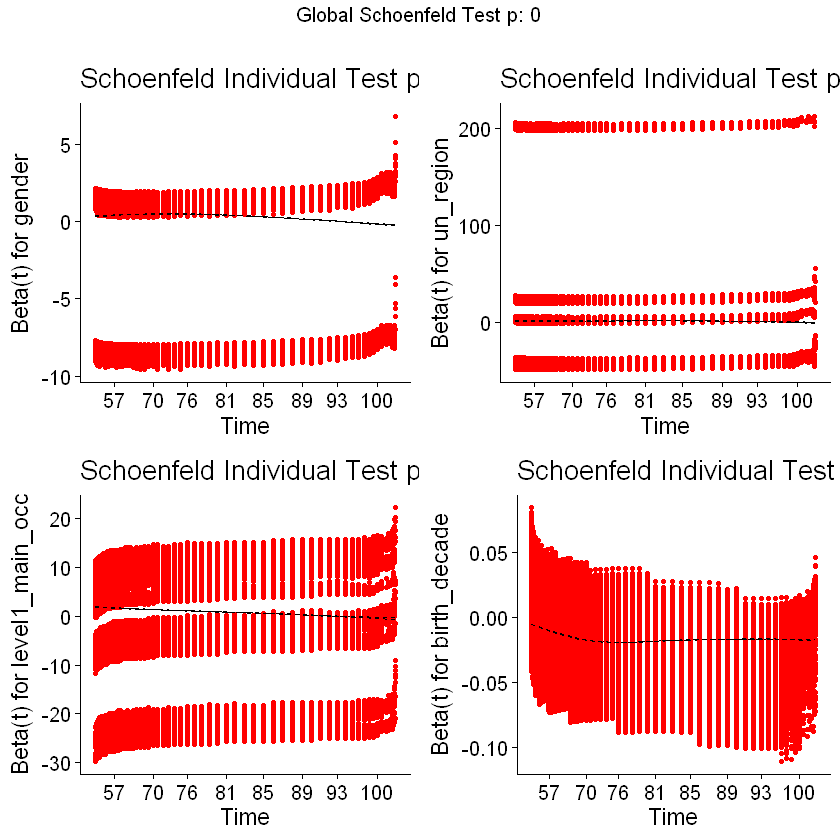

In [29]:
#### PH Diagnostics Check
ph_test <- cox.zph(cox_model)
print(ph_test)
ggcoxzph(ph_test)

In [30]:
summary(cox_model)


Call:
coxph(formula = Surv(survival_time_age, status) ~ gender + un_region + 
    level1_main_occ + birth_decade, data = bhht_clean_filtered)

  n= 1676602, number of events= 634850 

                                       coef  exp(coef)   se(coef)        z
genderMale                        0.3564205  1.4282080  0.0039999   89.107
un_regionAfrica                   0.1436028  1.1544255  0.0098709   14.548
un_regionAsia                     0.0027401  1.0027439  0.0055553    0.493
un_regionEurope                   0.0398316  1.0406355  0.0028543   13.955
un_regionOceania                  0.0275852  1.0279692  0.0066980    4.118
level1_main_occDiscovery/Science -0.2497554  0.7789913  0.0037967  -65.783
level1_main_occLeadership        -0.1121544  0.8939063  0.0031750  -35.325
level1_main_occSports/Games      -0.0295310  0.9709008  0.0037868   -7.798
birth_decade                     -0.0153840  0.9847338  0.0000421 -365.422
                                 Pr(>|z|)    
genderMale          

- Adding `birth_decade` captures cohort effects
- All individual p-values < 0.001, every covariate has some time-dependent behavior
- Test is picking up statistically significant violations, though substantively not very significant (`birth_decade` panel shows 0.05 effect size)
- Shows only mild curvature even for our very large sample.

- If we report Hazard Ratios, have to note that they are average effects across the age range rather than fixed throughout time

### Test Interactions

#### Gender x Region
- Hypothesis: Gender norms, life expectancy, healthcare access differs by region

In [31]:
cox_inter <- coxph(Surv(survival_time_age, status) ~ gender * un_region + level1_main_occ, data = bhht_clean_filtered)
anova(cox_age, cox_inter)
summary(cox_inter)

,loglik,Chisq,Df,Pr(>|Chi|)
,<dbl>,<dbl>,<int>,<dbl>
1,-8191472,NA,NA,NA
2,-8191421,100.5191,4,7.626593e-21


Call:
coxph(formula = Surv(survival_time_age, status) ~ gender * un_region + 
    level1_main_occ, data = bhht_clean_filtered)

  n= 1676602, number of events= 634850 

                                      coef exp(coef)  se(coef)       z Pr(>|z|)
genderMale                        0.380786  1.463434  0.006812  55.902  < 2e-16
un_regionAfrica                  -0.028888  0.971526  0.030376  -0.951    0.342
un_regionAsia                    -0.120515  0.886464  0.016743  -7.198 6.11e-13
un_regionEurope                   0.047323  1.048461  0.007992   5.922 3.19e-09
un_regionOceania                  0.017271  1.017421  0.020636   0.837    0.403
level1_main_occDiscovery/Science -0.199208  0.819380  0.003793 -52.525  < 2e-16
level1_main_occLeadership         0.001342  1.001343  0.003147   0.427    0.670
level1_main_occSports/Games      -0.170158  0.843531  0.003753 -45.336  < 2e-16
genderMale:un_regionAfrica       -0.029872  0.970570  0.032100  -0.931    0.352
genderMale:un_regionAsia       

- Male hazard is ~1.42× higher overall.
- Regional main effects small: slightly higher hazard in Europe/Oceania, lower in Asia.
- Significant interactions for Europe (+10%) and Oceania (+19%), meaning male disadvantage is strongest there.
- The gender gap in survival is amplified in Europe and Oceania, stable elsewhere.

#### Gender x Occupation
- Hypothesis: Occupational hazards and societal roles might differ across genders. Does this impact survival?


In [32]:
cox_inter <- coxph(Surv(survival_time_age, status) ~ gender * level1_main_occ + un_region, data = bhht_clean_filtered)

anova(cox_age, cox_inter)
summary(cox_inter)

,loglik,Chisq,Df,Pr(>|Chi|)
,<dbl>,<dbl>,<int>,<dbl>
1,-8191472,NA,NA,NA
2,-8191010,922.538,3,1.143746e-199


Call:
coxph(formula = Surv(survival_time_age, status) ~ gender * level1_main_occ + 
    un_region, data = bhht_clean_filtered)

  n= 1676602, number of events= 634850 

                                                 coef exp(coef)  se(coef)
genderMale                                   0.368933  1.446190  0.005273
level1_main_occDiscovery/Science            -0.138291  0.870845  0.010890
level1_main_occLeadership                   -0.117801  0.888873  0.009667
level1_main_occSports/Games                 -0.549836  0.577044  0.015547
un_regionAfrica                             -0.056579  0.944992  0.009856
un_regionAsia                               -0.136019  0.872826  0.005537
un_regionEurope                              0.110219  1.116523  0.002845
un_regionOceania                             0.126883  1.135284  0.006687
genderMale:level1_main_occDiscovery/Science -0.060654  0.941148  0.011618
genderMale:level1_main_occLeadership         0.135942  1.145615  0.010224
genderMale:level1

#### Region x Occupation
- Similar logic to the last one

In [33]:
cox_inter <- coxph(Surv(survival_time_age, status) ~ un_region * level1_main_occ + un_region, data = bhht_clean_filtered)

anova(cox_age, cox_inter)
summary(cox_inter)

,loglik,Chisq,Df,Pr(>|Chi|)
,<dbl>,<dbl>,<int>,<dbl>
1,-8191472,NA,NA,NA
2,-8196283,9623.254,11,0


Call:
coxph(formula = Surv(survival_time_age, status) ~ un_region * 
    level1_main_occ + un_region, data = bhht_clean_filtered)

  n= 1676602, number of events= 634850 

                                                       coef exp(coef)  se(coef)
un_regionAfrica                                    0.133152  1.142424  0.019644
un_regionAsia                                     -0.012383  0.987694  0.009277
un_regionEurope                                    0.064441  1.066562  0.004742
un_regionOceania                                  -0.068566  0.933732  0.016219
level1_main_occDiscovery/Science                  -0.253084  0.776403  0.007373
level1_main_occLeadership                         -0.036721  0.963945  0.005686
level1_main_occSports/Games                       -0.004035  0.995973  0.006492
un_regionAfrica:level1_main_occDiscovery/Science  -0.053240  0.948152  0.037213
un_regionAsia:level1_main_occDiscovery/Science    -0.060778  0.941032  0.017691
un_regionEurope:level1_main_

### Occupation x Birth Decade
- See if occupation's hazard differs significantly across cohorts

In [34]:
cox_inter <- coxph(Surv(survival_time_age, status) ~ level1_main_occ * birth_decade + gender + un_region, data = bhht_clean_filtered)

anova(cox_age, cox_inter)
summary(cox_inter)

,loglik,Chisq,Df,Pr(>|Chi|)
,<dbl>,<dbl>,<int>,<dbl>
1,-8191472,NA,NA,NA
2,-8127203,128537.5,4,0


Call:
coxph(formula = Surv(survival_time_age, status) ~ level1_main_occ * 
    birth_decade + gender + un_region, data = bhht_clean_filtered)

  n= 1676602, number of events= 634850 

                                                    coef  exp(coef)   se(coef)
level1_main_occDiscovery/Science               3.361e+00  2.882e+01  2.356e-01
level1_main_occLeadership                      2.164e-01  1.242e+00  1.909e-01
level1_main_occSports/Games                    1.341e+01  6.663e+05  2.415e-01
birth_decade                                  -1.395e-02  9.861e-01  7.186e-05
genderMale                                     3.535e-01  1.424e+00  4.003e-03
un_regionAfrica                                1.448e-01  1.156e+00  9.880e-03
un_regionAsia                                  4.697e-03  1.005e+00  5.560e-03
un_regionEurope                                4.430e-02  1.045e+00  2.857e-03
un_regionOceania                               1.452e-02  1.015e+00  6.707e-03
level1_main_occDiscovery/S

#### Region Specific Gender Nuance over Time

In [35]:
cox_inter <- coxph(Surv(survival_time_age, status) ~ gender * un_region * birth_decade + level1_main_occ, data = bhht_clean_filtered)
anova(cox_age, cox_inter)
summary(cox_inter)

,loglik,Chisq,Df,Pr(>|Chi|)
,<dbl>,<dbl>,<int>,<dbl>
1,-8191472,NA,NA,NA
2,-8128781,125381,14,0


Call:
coxph(formula = Surv(survival_time_age, status) ~ gender * un_region * 
    birth_decade + level1_main_occ, data = bhht_clean_filtered)

  n= 1676602, number of events= 634850 

                                               coef  exp(coef)   se(coef)
genderMale                                1.424e+00  4.152e+00  4.328e-01
un_regionAfrica                          -2.215e+00  1.092e-01  2.240e+00
un_regionAsia                             5.130e+00  1.691e+02  1.192e+00
un_regionEurope                           6.101e+00  4.465e+02  5.078e-01
un_regionOceania                          3.047e+00  2.105e+01  1.231e+00
birth_decade                             -1.406e-02  9.860e-01  2.116e-04
level1_main_occDiscovery/Science         -2.491e-01  7.795e-01  3.799e-03
level1_main_occLeadership                -1.102e-01  8.957e-01  3.180e-03
level1_main_occSports/Games              -2.804e-02  9.723e-01  3.792e-03
genderMale:un_regionAfrica               -1.035e+00  3.553e-01  2.351e+00
ge

---
# Calendar Year Based Survival Analysis

## Death Counts by Year

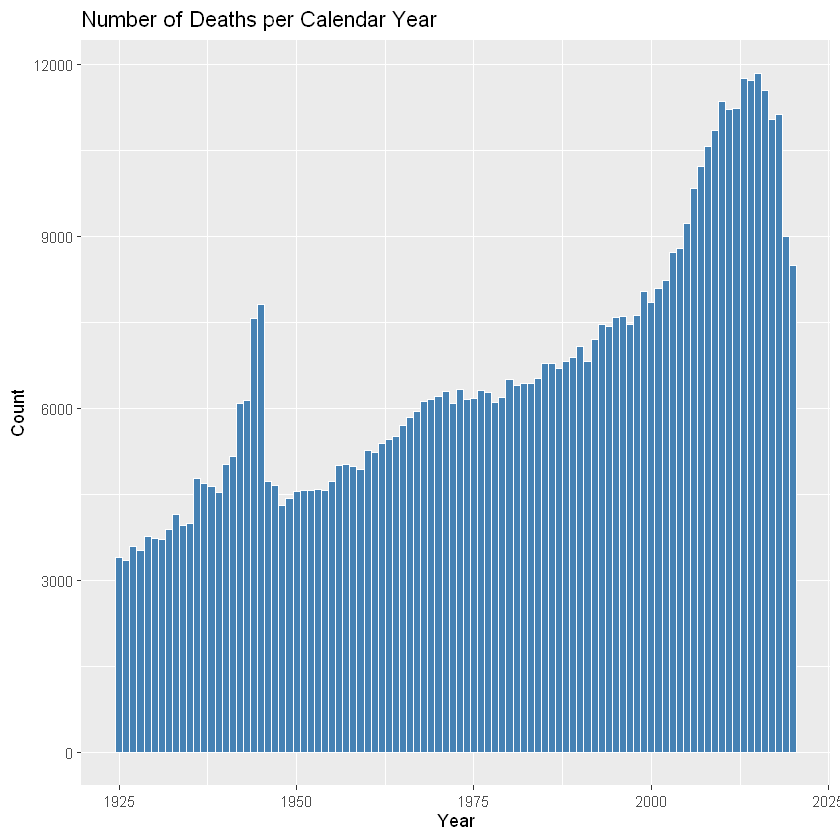

In [36]:
bhht_clean %>%
filter(status == 1) %>%
ggplot(aes(x = death_final)) +
geom_histogram(binwidth = 1, fill="steelblue", color="white") +
labs(title="Number of Deaths per Calendar Year", x="Year", y="Count")

In [37]:
death_counts <- bhht_clean %>%
    filter(status == 1) %>%
    group_by(death_final) %>%
    summarise(count = n()) %>%
    arrange(death_final)

# kable(death_counts, col.names = c("Year", "Number of Deaths"), caption = "Number of Deaths per Year")

`geom_smooth()` using formula = 'y ~ x'


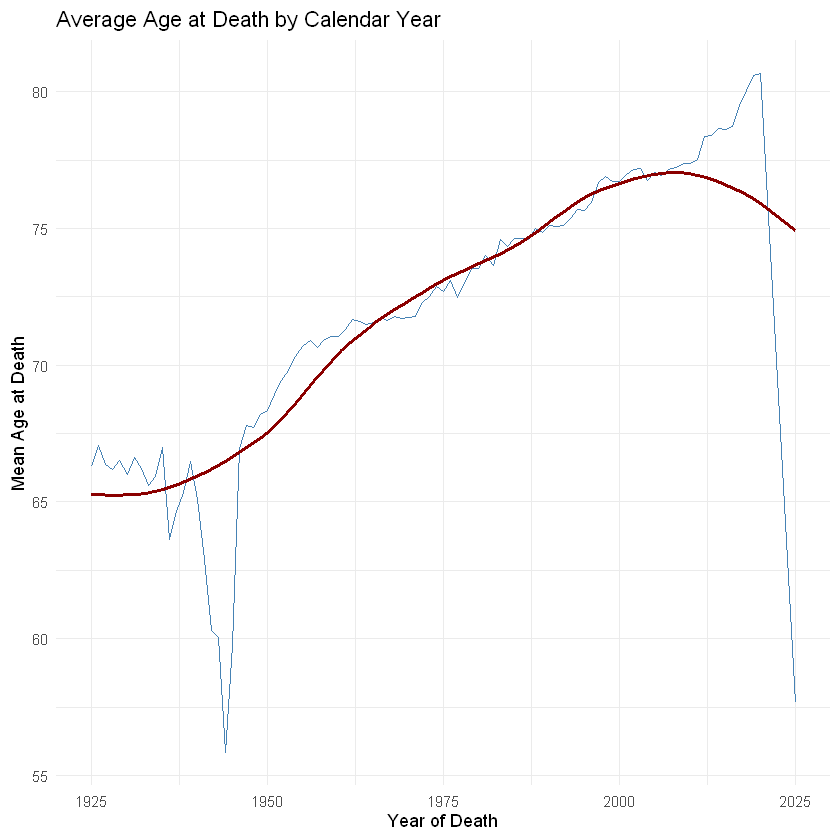

In [38]:
bhht_clean %>%
  group_by(death_final) %>%
  summarise(mean_age = mean(survival_time_age, na.rm = TRUE)) %>%
  ggplot(aes(x = death_final, y = mean_age)) +
  geom_line(color = "steelblue") +
  geom_smooth(method = "loess", color = "darkred", se = FALSE) +
  labs(
    title = "Average Age at Death by Calendar Year",
    x = "Year of Death",
    y = "Mean Age at Death"
  ) +
  theme_minimal()

- Average age of death skews sharply downward in 1940s. Likely due to war
- Average age of death rises over time. People may be healthier, higher quality of living, time of peace, etc.
- See a decrease in 2015 onward, could be related to COVID, the fact that this is likely an upper limit on maximum age for those born in the past 100 years.

## Maps of Deaths by Decade

In [39]:
plot <- FALSE

In [40]:
library(ggplot2)
library(dplyr)
library(maps)
library(viridis)

if(plot){
  # Filter and prepare data
  death_map <- bhht_clean %>%
    # Valid coordinates and death years
    filter(!is.na(dpla1), !is.na(dplo1),
          dpla1 >= -90, dpla1 <= 90,
          dplo1 >= -180, dplo1 <= 180,
          !is.na(death_final)) %>%
    mutate(decade = floor(death_final / 10) * 10) %>%
    filter(decade >= cutoff_year, decade <= current_year)

  # Load world map data
  world <- map_data("world")

  # Create output folders
  if (!dir.exists("plots")) dir.create("plots")
  if (!dir.exists("plots/total")) dir.create("plots/total")

  unique_decades <- sort(unique(death_map$decade))

  for (decade in unique_decades) {
    decade_data <- death_map %>% filter(decade == !!decade)
    
    p <- ggplot() +
      geom_polygon(
        data = world,
        aes(x = long, y = lat, group = group),
        color = "gray70", fill = "gray95", size = 0.2
      ) +
      stat_density_2d(
        data = decade_data,
        aes(x = dplo1, y = dpla1, fill = ..level.., alpha = ..level..),
        geom = "polygon", bins = 30
      ) +
      scale_fill_viridis_c(option = "plasma") +
      scale_alpha(range = c(0.2, 0.6), guide = "none") +
      coord_fixed(1.3) +
      theme_minimal() +
      labs(
        title = paste("Geographic Density of Death Locations -", decade),
        subtitle = "Notable individuals in BHHT dataset",
        x = "Longitude",
        y = "Latitude",
        fill = "Density"
      )
    
    ggsave(filename = paste0("plots/total/death_density_", decade, ".png"),
          plot = p, width = 10, height = 6, dpi = 300)
  }
}

Warning message:
"package 'maps' was built under R version 4.4.3"

Attaching package: 'maps'


The following object is masked from 'package:viridis':

    unemp


The following object is masked from 'package:purrr':

    map




In [41]:
library(dplyr)
library(ggplot2)
library(maps)
library(viridis)

if(plot){
  set.seed(42)

  death_map <- bhht_clean %>%
    filter(
      !is.na(dpla1), !is.na(dplo1),
      dpla1 >= -90, dpla1 <= 90,
      dplo1 >= -180, dplo1 <= 180,
      !is.na(death_final),
      !is.na(un_region)
    ) %>%
    mutate(decade = floor(death_final / 10) * 10) %>%
    filter(decade >= cutoff_year, decade <= current_year)

  world <- map_data("world")

  if (!dir.exists("plots")) dir.create("plots")
  if (!dir.exists("plots/regions")) dir.create("plots/regions")

  unique_decades <- sort(unique(death_map$decade))
  for (decade in unique_decades) {
    
    # Subset to current decade and calculate counts
    decade_data <- death_map %>%
      filter(decade == !!decade) %>%
      group_by(dpla1, dplo1, un_region) %>%
      summarise(count = n(), .groups = "drop") %>%
      group_by(un_region) %>%
      group_modify(~ {
        n_take <- min(10000, nrow(.x))
        dplyr::slice_sample(.x, n = n_take)
      }) %>%
      ungroup()
    
    p <- ggplot() +
      geom_polygon(
        data = world,
        aes(x = long, y = lat, group = group),
        color = "gray70", fill = "gray95", size = 0.2
      ) +
      geom_point(
        data = decade_data,
        aes(x = dplo1, y = dpla1, color = un_region, size = count),
        alpha = 0.5
      ) +
      scale_color_brewer(palette = "Set1") +
      scale_size_continuous(range = c(1, 5), guide = "legend") +
      coord_fixed(1.3) +
      theme_minimal() +
      labs(
        title = paste("Death Locations by UN Region -", decade),
        subtitle = "Point size represents the number of deaths",
        x = "Longitude",
        y = "Latitude",
        color = "UN Region",
        size = "Number of Deaths"
      )
    
    ggsave(
      filename = paste0("plots/regions/death_points_", decade, ".png"),
      plot = p,
      width = 10,
      height = 6,
      dpi = 300
    )
    
    message("Saved plot for decade ", decade)
  }
}

- Points are colored by the birthplace of the individual, and may be somewhat interesting trying to see if people migrate from their birthplace. 
- Honestly it's been really difficult trying to perform surv analysis on the calendar year lol

---
# Stratification for Rachael

## Stratify by Birth Decade
- I believe this is the most correct route forward?

In [42]:
cox_strat <- coxph(
  Surv(survival_time_age, status) ~ gender + un_region + level1_main_occ + 
    strata(birth_decade),
  data = bhht_clean_filtered
)

summary(cox_strat)


Call:
coxph(formula = Surv(survival_time_age, status) ~ gender + un_region + 
    level1_main_occ + strata(birth_decade), data = bhht_clean_filtered)

  n= 1676602, number of events= 634850 

                                      coef exp(coef)  se(coef)       z Pr(>|z|)
genderMale                        0.365747  1.441591  0.004009  91.227  < 2e-16
un_regionAfrica                   0.205052  1.227589  0.009880  20.755  < 2e-16
un_regionAsia                     0.012577  1.012656  0.005558   2.263   0.0236
un_regionEurope                   0.040251  1.041072  0.002856  14.091  < 2e-16
un_regionOceania                  0.026660  1.027018  0.006705   3.976 7.00e-05
level1_main_occDiscovery/Science -0.232666  0.792419  0.003797 -61.272  < 2e-16
level1_main_occLeadership        -0.086151  0.917455  0.003171 -27.167  < 2e-16
level1_main_occSports/Games      -0.018497  0.981673  0.003803  -4.864 1.15e-06
                                    
genderMale                       ***
un_regionAfric

## Stratify by Gender
- From what I can tell from those Schoenfeld plots, this is not the correct analysis as gender isn't the problematic variable, birth_decade is.
- Stratifying by gender also means we lose out on the ability to calculate a HR for gender specifically.

In [43]:
cox_strat <- coxph(
  Surv(survival_time_age, status) ~ strata(gender) + un_region + level1_main_occ,
  data = bhht_clean_filtered
)

summary(cox_strat)

Call:
coxph(formula = Surv(survival_time_age, status) ~ strata(gender) + 
    un_region + level1_main_occ, data = bhht_clean_filtered)

  n= 1676602, number of events= 634850 

                                      coef exp(coef)  se(coef)       z Pr(>|z|)
un_regionAfrica                  -0.056663  0.944912  0.009856  -5.749 8.98e-09
un_regionAsia                    -0.136865  0.872088  0.005537 -24.719  < 2e-16
un_regionEurope                   0.107436  1.113420  0.002844  37.782  < 2e-16
un_regionOceania                  0.128290  1.136882  0.006687  19.184  < 2e-16
level1_main_occDiscovery/Science -0.197497  0.820783  0.003792 -52.082  < 2e-16
level1_main_occLeadership         0.002634  1.002637  0.003148   0.837    0.403
level1_main_occSports/Games      -0.169882  0.843764  0.003751 -45.285  < 2e-16
                                    
un_regionAfrica                  ***
un_regionAsia                    ***
un_regionEurope                  ***
un_regionOceania                 **

## Time Dependent Covariates
- Add a time-interaction to see if gender's effect changes with log time

Potential Issues?
- These coefficients are massive (100x magnitude)
- Model is numerically unstable
- This is trying to fix the PH violation through gender, which is not where the violation is
    - But since birth_decade/survival_time_age aren't technically continuous, I'm unsure if we can use them here
- Concordance almost seems TOO high now?

In [44]:
cox_tdc <- coxph(
  Surv(survival_time_age, status) ~ gender + un_region + level1_main_occ +
    gender:log(survival_time_age),
  data = bhht_clean_filtered
)

summary(cox_tdc)

Warning message in coxph(Surv(survival_time_age, status) ~ gender + un_region + :
"a variable appears on both the left and right sides of the formula"
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
"Ran out of iterations and did not converge"
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
"one or more coefficients may be infinite"


Call:
coxph(formula = Surv(survival_time_age, status) ~ gender + un_region + 
    level1_main_occ + gender:log(survival_time_age), data = bhht_clean_filtered)

  n= 1676602, number of events= 634850 

                                          coef  exp(coef)   se(coef)          z
genderMale                           2.389e+00  1.090e+01  3.697e-03     646.21
un_regionAfrica                     -4.199e-01  6.571e-01  9.709e-03     -43.25
un_regionAsia                       -3.477e-01  7.063e-01  5.198e-03     -66.89
un_regionEurope                      1.237e-01  1.132e+00  2.551e-03      48.48
un_regionOceania                     2.142e-01  1.239e+00  6.347e-03      33.76
level1_main_occDiscovery/Science     4.496e-02  1.046e+00  3.437e-03      13.08
level1_main_occLeadership            1.669e-01  1.182e+00  2.751e-03      60.69
level1_main_occSports/Games         -5.596e-01  5.714e-01  3.543e-03    -157.98
genderFemale:log(survival_time_age) -1.703e+02  1.148e-74  8.675e-04 -196265.24

## Multiple Time Interactions
- This model is unstable
- Interactions make no sense due to instability
    - Men have 319x higher hazard than baseline

- Disagrees with Schoenfeld
    - We saw before birth_decade is a known violation of proportional hazards assumption. This model is forcing additional interactions with time (gender, region, occ)

In [45]:
cox_full_tdc <- coxph(
  Surv(survival_time_age, status) ~ 
    gender + un_region + level1_main_occ +
    gender:log(survival_time_age) +
    un_region:log(survival_time_age) +
    level1_main_occ:log(survival_time_age),
  data = bhht_clean_filtered
)

summary(cox_full_tdc)


Warning message in coxph(Surv(survival_time_age, status) ~ gender + un_region + :
"a variable appears on both the left and right sides of the formula"
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
"Ran out of iterations and did not converge"
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
"one or more coefficients may be infinite"


Call:
coxph(formula = Surv(survival_time_age, status) ~ gender + un_region + 
    level1_main_occ + gender:log(survival_time_age) + un_region:log(survival_time_age) + 
    level1_main_occ:log(survival_time_age), data = bhht_clean_filtered)

  n= 1676602, number of events= 634850 

                                                              coef  exp(coef)
genderMale                                               5.766e+00  3.192e+02
un_regionAfrica                                          1.266e+00  3.547e+00
un_regionAsia                                           -1.360e+00  2.567e-01
un_regionEurope                                          3.863e-01  1.472e+00
un_regionOceania                                         4.011e-01  1.493e+00
level1_main_occDiscovery/Science                         4.538e+00  9.349e+01
level1_main_occLeadership                                3.910e+00  4.990e+01
level1_main_occSports/Games                             -2.362e+00  9.426e-02
genderFemale:log